
# Projet Maison 2

In [1]:
# import des modules usuels
import numpy as np
import pandas as pd

# options d'affichage
pd.set_option("display.min_rows", 16)

In [2]:
# chargement et traitement des données
GEO = pd.read_csv("correspondance-code-insee-code-postal.csv",
                   sep=';',
                   usecols=range(11),
                   index_col="Code INSEE")

# A COMPLETER avec les colonnes
# - lat, lon : latitude et longitude des communes
# - cp_ville : Code Postal + " " + "Commune"
GEO.head(3)

,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape
Code INSEE,,,,,,,,,,
31080,31350,BOULOGNE-SUR-GESSE,HAUTE-GARONNE,MIDI-PYRENEES,Chef-lieu canton,301.0,2470.0,1.6,"43.2904403081, 0.650641474176","{""type"": ""Polygon"", ""coordinates"": [[[0.671852..."
11143,11510,FEUILLA,AUDE,LANGUEDOC-ROUSSILLON,Commune simple,314.0,2426.0,0.1,"42.9291375888, 2.90138923544","{""type"": ""Polygon"", ""coordinates"": [[[2.906996..."
43028,43200,BESSAMOREL,HAUTE-LOIRE,AUVERGNE,Commune simple,888.0,743.0,0.4,"45.1306448726, 4.07952494849","{""type"": ""Polygon"", ""coordinates"": [[[4.091674..."


**Partie A**

- Compléter le chargement des données en ajoutant au dataframe `GEO`
    - les colonnes "lat" et "lon" avec la latitude et la longitude des communes
    - une colonne "cp_ville" avec le Code Postal + un espace + et le nom de la Commune
- Ecrire une fonction `search_city(lat, lon)` qui retourne le "cp_ville" de la commune la plus proche d'un point à partir de sa latitude et sa longitude.
- Ecrire une fonction `dms2dec(deg, min, sec)` qui convertit les degrés, minutes, secondes en valeur numérique pour pouvoir utiliser la fonction précédente avec un GPS.

In [3]:
# Ajout des colonnes "lat", "lon" et "cp_ville"
GEO['lat'] = GEO['geo_point_2d'].apply(lambda x: float(x.split(', ')[0]))
GEO['lon'] = GEO['geo_point_2d'].apply(lambda x: float(x.split(', ')[1]))
GEO['cp_ville'] = GEO['Code Postal'] + " " + GEO['Commune']

# Affichage de ces colonnes (5 premières lignes uniquement)
GEO[['lat','lon','cp_ville']].head()

,lat,lon,cp_ville
Code INSEE,,,
31080,43.290440,0.650641,31350 BOULOGNE-SUR-GESSE
11143,42.929138,2.901389,11510 FEUILLA
43028,45.130645,4.079525,43200 BESSAMOREL
78506,48.526763,1.805140,78660 PRUNAY-EN-YVELINES
84081,43.933779,4.908759,84310 MORIERES-LES-AVIGNON


###### Formule de Haversine (pour calculer la distance entre deux points quelconques à partir de leurs latitudes et leurs longitudes) :

$$D=2R\arcsin \left({\sqrt {\sin ^{2}{\left({\frac {lat_2 - lat_1}{2}}\right)}+\cos {(lat_1)}\cdot \cos {(lat_2)}\cdot \sin ^{2}{\left({\frac {lon_2 - lon_1}{2}}\right)}\ }}\right)$$

In [4]:
# fonction recherche de ville

def search_city(lat, long):
    
    # Cette fonction permet de calculer la distance (en km) entre deux points 
    # en se basant sur leurs coordonnées respectives (lat1, lon1) et (lat2, lon2)
    def distance(lat1, lon1, lat2, lon2):
        
        import math
        R = 6371 # Rayon de la terre en km
        phi1 = math.radians(lat1)
        phi2 = math.radians(lat2)
        dlat = math.radians(lat2-lat1)
        dlon = math.radians(lon2-lon1)
        ### En utilisant la formule de Haversine ci-dessus
        a = math.sin(dlat/2)**2 + (math.cos(phi1))*(math.cos(phi2))*(math.sin(dlon/2)**2)
        D = 2 * R * math.asin(math.sqrt(a))

        return D
    
    # "df" permet d'affecter à chaque "cp_ville" la distance qui le sépare avec le point de coordonnées (lat, long)
    # ==> Pour le calcul des distances, on a utilisé la fonction 'distance' ci-dessus
    df = pd.concat(
        [GEO['cp_ville'], ### Colonne des "cp_ville"
         GEO.apply(lambda x: distance(lat, long, x.lat, x.lon), axis=1).rename("Distance en km")], ### Colonnes des distances
         axis=1).reset_index(drop=True)
    
    # A partir de "df", on peut déduire le "cp_ville" de la commune la plus proche du point défini par (lat, long)
    cp_ville = df.iloc[df['Distance en km'].idxmin(), 0]
    
    return cp_ville

In [5]:
# conversion degrés, minutes, secondes => décimal
def dms2dec(deg, mn, sec):
    return deg + (mn/60) + (sec/3600)

In [6]:
# on applique la fonction à une coordonnée tirée au hasard
np.random.seed(0)
a, b = 41.5, 51.1  # latitude min et max de la France métropolitaine
lat = np.random.uniform(a, b)
a, b = -5.1, 9.5  # longitude min et max de la France métropolitaine
lon = np.random.uniform(a, b)

search_city(lat, lon)

'71330 BOSJEAN'

In [7]:
# à partir de coordonnées GPS précises
search_city(dms2dec(48, 42, 52), dms2dec(2, 14, 45))

'91120 PALAISEAU'

**Partie B**

La colonne "geo_shape" comporte des chaines de catactères au format JSON. Elles représentent les formes géométriques des communes qui sont soit des polygones soit composées de plusieurs polygones.

- Utiliser la librairie Python **json** pour parser les valeurs de la colonne "geo_shape" et mettre le résultat (`Series`) dans la variable `GEO_SHAPE`.
- Ecrire une fonction `get_types()` qui retourne le décompte (`value_counts()`) des valeurs accédées avec la clé "type".
- Ecrire une fonction `get_coordinates_len()` qui retourne le décompte (`value_counts()`) des longueurs des listes accédées avec la clé "coordinates".
- Ecrire une fonction `get_most_complex_city()` qui retourne la commune est constituée du plus grand nombre de polygones ?
- Ecrire une fonction `get_nb_cities_2_polygons()` qui retourne  le nombre de villes qui sont de type "Polygon" mais dont la longueur des listes accédées avec la clé "coordinates" vaut 2 ?
- **Facultatif :**
- Pour ces villes vérifier que le premier polygone contient bien le second (enclave). NB : on pourra installer la librairie **shapely**, utiliser la classe Polygon de **shapely.geometry**  et la méthode `contains()`. Sur Windows **shapely** peut nécessiter d'installer manuellement la dll "geos_c.dll" dans le répertoire "Library/bin" de votre environnement Python.

In [8]:
# GEO_SHAPE
import json
# La variable GEO_SHAPE doit contenir une Serie
# correspondant aux valeurs de la colonne "geo_shape" parsées avec la librairie json

geo_shape_list = []

# On parse les valeurs de la colonne "geo_shape" (en utilisant 'json.loads') et on les stocke dans une liste 'geo_shape_list'
for x in GEO['geo_shape']:
    geo_shape_list.append(json.loads(x))

# On convertit la liste 'geo_shape_list' en série et on met le résultat dans la variable 'GEO_SHAPE'
GEO_SHAPE = pd.Series(geo_shape_list)

GEO_SHAPE

0        {'type': 'Polygon', 'coordinates': [[[0.671852...
1        {'type': 'Polygon', 'coordinates': [[[2.906996...
2        {'type': 'Polygon', 'coordinates': [[[4.091674...
3        {'type': 'Polygon', 'coordinates': [[[1.829610...
4        {'type': 'Polygon', 'coordinates': [[[4.927176...
5        {'type': 'Polygon', 'coordinates': [[[1.849459...
6        {'type': 'Polygon', 'coordinates': [[[-0.71016...
7        {'type': 'Polygon', 'coordinates': [[[-0.66124...
                               ...                        
36734    {'type': 'Polygon', 'coordinates': [[[2.302124...
36735    {'type': 'Polygon', 'coordinates': [[[1.205457...
36736    {'type': 'Polygon', 'coordinates': [[[3.258096...
36737    {'type': 'Polygon', 'coordinates': [[[6.026228...
36738    {'type': 'Polygon', 'coordinates': [[[8.106826...
36739    {'type': 'Polygon', 'coordinates': [[[4.356584...
36740    {'type': 'Polygon', 'coordinates': [[[4.926593...
36741    {'type': 'Polygon', 'coordinates': [[[-0.99753.

In [9]:
# value_counts des valeurs "type"
def get_types():
    ### On définit une série qui contient les valeurs accédées avec la clé "type"
    types = pd.DataFrame(list(GEO_SHAPE))['type']
    
    return types.value_counts()
    
get_types()

Polygon         36670
MultiPolygon       72
Name: type, dtype: int64

In [10]:
# value_counts des longueurs de "coordinates"
def get_coordinates_len():
    ### On définit une série qui contient les valeurs accédées avec la clé "coordinates"
    coordinates = pd.DataFrame(list(GEO_SHAPE))['coordinates']
    
    return coordinates.str.len().value_counts()
     
get_coordinates_len()

1    36660
2       80
3        1
4        1
Name: coordinates, dtype: int64

In [11]:
# commune constituée du plus grand nombre de polygones
def get_most_complex_city():
    ### On fusionne les colonnes "cp_ville", "type" et "coordinates"
    df = pd.concat([GEO['cp_ville'].reset_index(drop=True), pd.DataFrame(list(GEO_SHAPE))], axis=1)
    
    return df.iloc[df['coordinates'].str.len().idxmax(), 0]
    
get_most_complex_city()

'83400 HYERES'

In [12]:
# nombre de villes qui sont de type "Polygon" mais dont la longueur des listes accédées avec la clé "coordinates" vaut 2
def get_nb_cities_2_polygons():
    df = pd.DataFrame(list(GEO_SHAPE))
    return len(df.loc[(df['type']=="Polygon") & (df['coordinates'].str.len()==2)])
    
get_nb_cities_2_polygons()

10

In [13]:
# Pour ces villes, vérifier que le premier polygone contient bien le second (enclave)
from shapely.geometry import Polygon

df = pd.concat([GEO['cp_ville'].reset_index(drop=True), pd.DataFrame(list(GEO_SHAPE))], axis=1)
df = df.loc[(df['type']=="Polygon") & (df['coordinates'].str.len()==2)].reset_index(drop=True)

for index, row in df.iterrows():
    polyA = Polygon(row['coordinates'][0])   ### Premier polygone
    polyB = Polygon(row['coordinates'][0])   ### Deuxième polygone
    print(polyA.contains(polyB))   ### On vérifie que polyA contient polyB

True
True
True
True
True
True
True
True
True
True


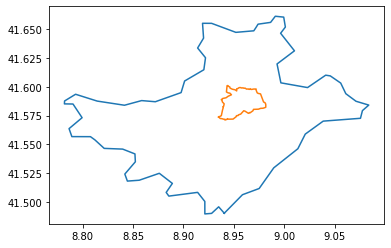

In [14]:
# Pour illustrer ceci, on fait appel au module pyplot de matplotlib
import matplotlib.pyplot as plt

# Dans cette exemple, on a considéré la première commune (d'indice 0) dans notre liste
polyA = Polygon(df['coordinates'][0][0])
polyB = Polygon(df['coordinates'][0][1])

# L'attribut 'exterior.xy' nous permet d'extraire les coordonnées des sommets d'un polygone
# xa et ya sont respectivement les longitudes et les latitudes des sommets de polyA, et elles sont de type 'array'
# Même chose pour xb et yb
xa,ya = polyA.exterior.xy
xb,yb = polyB.exterior.xy

plt.plot(xa,ya)
plt.plot(xb,yb)

plt.show()

In [15]:
# tests
import unittest

class Session2Test(unittest.TestCase):
    
    def test_partie_A1(self):
        # on applique la fonction cherche_ville() à une coordonnée tirée au hasard
        np.random.seed(0)
        a, b = 41.5, 51.1  # latitude min et max de la France métropolitaine
        lat = np.random.uniform(a, b)
        a, b = -5.1, 9.5  # longitude min et max de la France métropolitaine
        lon = np.random.uniform(a, b)

        cp_ville = search_city(lat, lon)
        self.assertEqual(cp_ville, "71330 BOSJEAN")
        
    def test_partie_A2(self):
        # à partir de coordonnées GPS précises
        cp_ville = search_city(dms2dec(48, 42, 52), dms2dec(2, 14, 45))
        self.assertEqual(cp_ville, "91120 PALAISEAU")
        
    def test_partie_B1(self):
        # check types
        dico = get_types()
        self.assertEqual(dico["Polygon"], 36670)
        self.assertEqual(dico["MultiPolygon"], 72)
        
    def test_partie_B2(self):
        # check coordinates len
        dico = get_coordinates_len()
        self.assertEqual(dico[1], 36660)
        self.assertEqual(dico[2], 80)
       
    def test_partie_B3(self):
        # check most complex city
        cp_ville = get_most_complex_city()
        self.assertEqual(cp_ville, "83400 HYERES")
        
    def test_partie_B4(self):
        # check nb cities 2 polygons
        nb = get_nb_cities_2_polygons()
        self.assertEqual(nb, 10)

In [16]:
# run tests
def run_tests():
    test_suite = unittest.makeSuite(Session2Test)
    runner = unittest.TextTestRunner(verbosity=2)
    runner.run(test_suite)
    
run_tests()

test_partie_A1 (__main__.Session2Test) ... ok
test_partie_A2 (__main__.Session2Test) ... ok
test_partie_B1 (__main__.Session2Test) ... ok
test_partie_B2 (__main__.Session2Test) ... ok
test_partie_B3 (__main__.Session2Test) ... ok
test_partie_B4 (__main__.Session2Test) ... ok

----------------------------------------------------------------------
Ran 6 tests in 1.868s

OK
